In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import geopandas as gpd
import mapclassify
from skimpy import clean_columns
import contextily as cx
import requests
import gudhi as gd

In [270]:
plt.rcParams['figure.figsize'] = [12, 8]

In [271]:
# pandas display options
pd.options.display.float_format = '{:.4f}'.format

## Read in Data

In [272]:
# LA County Census Tracts and SVI 
svi = gpd.read_file('Data/svi_tracts.geojson')

# LACoFD station locations
lacofd_stations = gpd.read_file('Data/LACoFD_stations.geojson')

# LACoFD station boundaries
lacofd_station_bounds = gpd.read_file('Data/LACoFD_station_boundaries.geojson')

# LAFD station locations
lafd_stations = gpd.read_file('Data/lafd_stations.geojson')

# LAFD station boundaries
lafd_station_bounds = gpd.read_file('Data/lafd_station_boundaries.geojson')

# all fire stations serving LA county
all_stations = gpd.read_file('Data/all_stations.geojson')

In [273]:
# LA county boundary (useful for plotting)
url = 'https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/15/query?outFields=*&where=1%3D1&f=geojson'
data = requests.get(url)
county_bound = gpd.GeoDataFrame.from_features(data.json())

# set crs
county_bound = county_bound.set_crs('EPSG:4326')

In [274]:
# set crs
svi = svi.to_crs('EPSG:2229')
lacofd_stations = lacofd_stations.to_crs('EPSG:2229')
lacofd_station_bounds = lacofd_station_bounds.to_crs('EPSG:2229')
lafd_stations = lafd_stations.to_crs('EPSG:2229')
lafd_station_bounds = lafd_station_bounds.to_crs('EPSG:2229')
all_stations = all_stations.to_crs('EPSG:2229')
county_bound = county_bound.to_crs('EPSG:2229')

In [275]:
svi['centroid'] = svi['geometry'].centroid

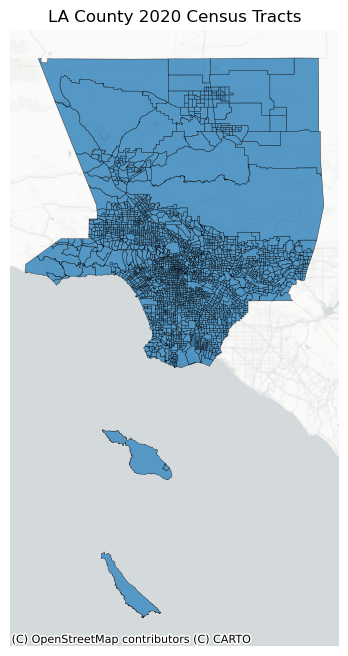

In [254]:
ax = svi.to_crs('EPSG:2229').plot(linewidth = 0.3, edgecolor = 'k', alpha = 0.75)
ax.set(title = 'LA County 2020 Census Tracts')
cx.add_basemap(ax, crs = 'EPSG:2229', source = cx.providers.CartoDB.PositronNoLabels)
plt.axis('off')
plt.savefig('Figures/census_tracts1.png', bbox_inches = 'tight', dpi = 600)

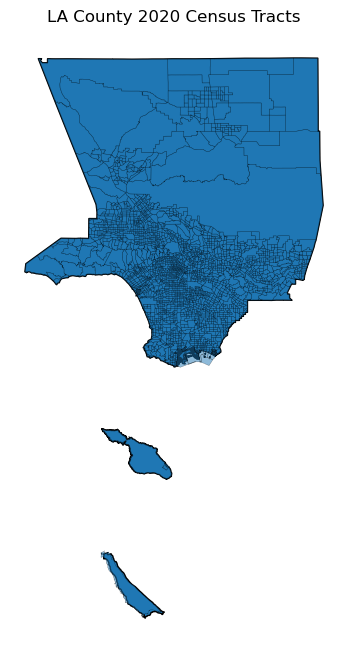

In [255]:
ax = county_bound.to_crs('EPSG:2229').plot(edgecolor = 'k')
svi.plot(ax = ax, alpha = 0.5, edgecolor = 'k', linewidth = 0.25)
ax.set(title = 'LA County 2020 Census Tracts')
plt.axis('off')
plt.savefig('Figures/census_tracts2.png', bbox_inches = 'tight', dpi = 600)

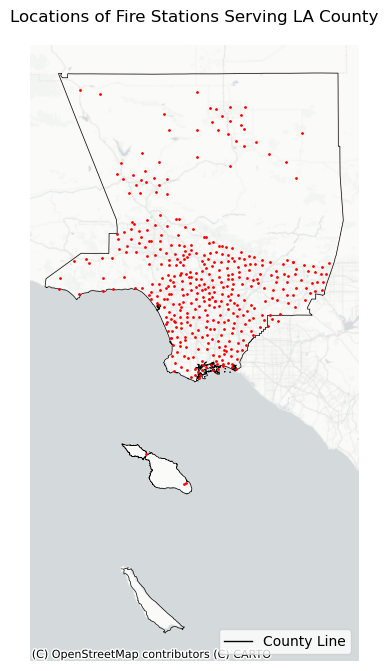

In [256]:
ax = county_bound.boundary.plot(color = 'k', linewidth = 0.5, zorder = 1)
all_stations.plot(ax = ax, markersize = 1, color = 'r', marker = 'o', zorder = 2)
cx.add_basemap(ax, crs = 'EPSG:2229', source = cx.providers.CartoDB.PositronNoLabels)
legend_elements = [Line2D([0], [0], color = 'k', lw = 1, label = 'County Line')]
ax.legend(loc = 'lower right', handles = legend_elements)
ax.set(title = 'Locations of Fire Stations Serving LA County')
plt.axis('off')
plt.savefig('Figures/fire_station_locations.png', bbox_inches = 'tight', dpi = 600)

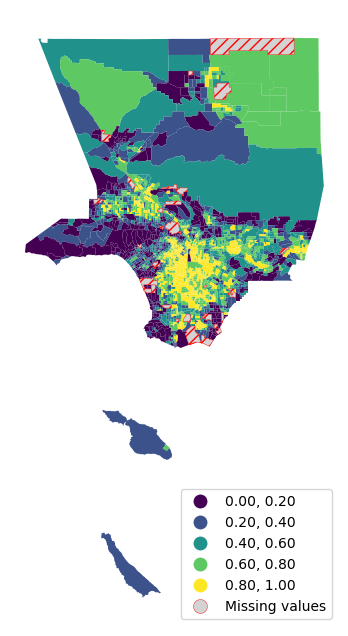

In [257]:
ax = svi.plot(
    column = 'rpl_themes',
    scheme = 'EqualInterval',
    cmap = 'viridis',
    legend = True,
    legend_kwds = {
        'loc': 'lower right'
    },
    missing_kwds = {
        'color': 'lightgrey',
        "edgecolor": 'r',
        'linewidth': 0.3,
        "hatch": '///',
        "label": 'Missing values'
    },
)
plt.axis('off')
plt.savefig('Figures/svi_percentile_ranking.png', bbox_inches = 'tight', dpi = 600)

In [258]:
# geoseries of union of all geometries from lacofd_station_bounds
lacofd_bounds_union = gpd.GeoSeries(lacofd_station_bounds.union_all())

In [259]:
# geoseries of union of all geometries from lafd_station_bounds
lafd_bounds_union = gpd.GeoSeries(lafd_station_bounds.union_all())

In [ ]:
# union of lacofd coverage and lafd coverage
lacofd_lafd_union = lacofd_station_bounds.overlay(lafd_station_bounds, how = 'union')

In [261]:
# areas not covered by lafd and lafd
non_lacofd_lafd = county_bound.overlay(lacofd_lafd_union, how = 'difference')

c:\Users\giova\anaconda3\envs\tda\Lib\site-packages\geopandas\geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 874 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


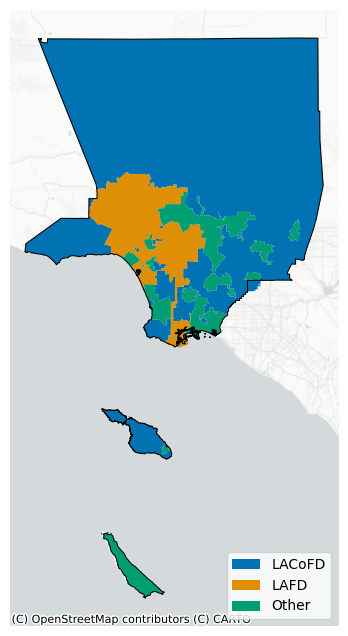

In [262]:
ax = county_bound.boundary.plot(color = 'k', linewidth = 0.75)
lacofd_bounds_union.plot(ax = ax, color = '#0173b2')
lafd_bounds_union.plot(ax = ax, color = '#de8f05')
non_lacofd_lafd.plot(ax = ax, color = '#029e73')
cx.add_basemap(ax, crs = 'EPSG:2229', source = cx.providers.CartoDB.PositronNoLabels)
legend_elements = [
    Patch(facecolor = '#0173b2', label = 'LACoFD'),
    Patch(facecolor = '#de8f05', label = 'LAFD'),
    Patch(facecolor = '#029e73', label = 'Other')
]
ax.legend(loc = 'lower right', handles = legend_elements)
plt.axis('off')
plt.savefig('Figures/department_boundaries.png', bbox_inches = 'tight', dpi = 600)

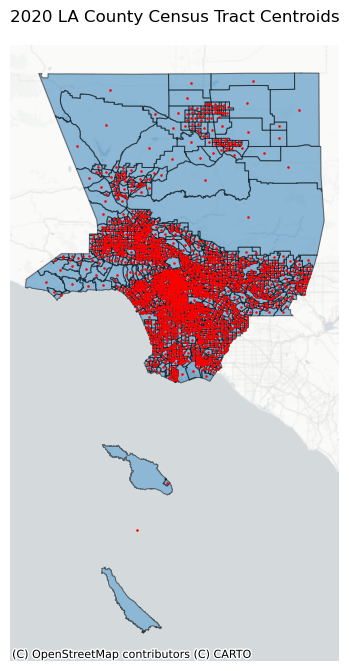

In [263]:
ax = svi.plot(alpha = 0.5, edgecolor = 'k', linewidth = 0.75)
svi['centroid'].plot(ax = ax, color = 'r', markersize = 0.75)
ax.set(title = '2020 LA County Census Tract Centroids')
cx.add_basemap(ax, crs = 'EPSG:2229', source = cx.providers.CartoDB.PositronNoLabels)
plt.axis('off');
plt.savefig('Figures/tract_centroids.png', bbox_inches = 'tight', dpi = 600)

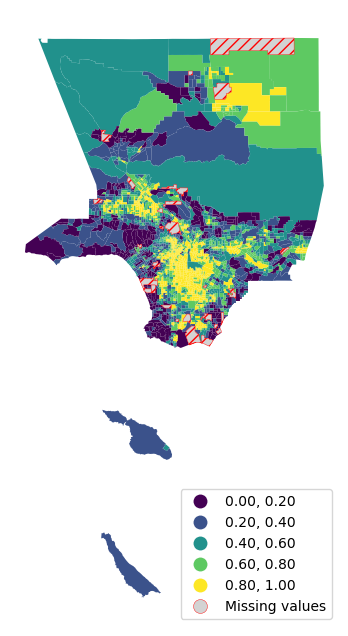

In [264]:
ax = svi.plot(
    column = 'rpl_theme_1',
    scheme = 'equal_interval',
    cmap = 'viridis',
    legend = True,
    legend_kwds = {
        'loc': 'lower right'
    },
    missing_kwds = {
        'color': 'lightgrey',
        "edgecolor": 'r',
        'linewidth': 0.3,
        "hatch": '///',
        "label": 'Missing values'
    },
)
plt.axis('off')
plt.savefig('Figures/theme1_percentile_ranking.png', bbox_inches = 'tight', dpi = 600)

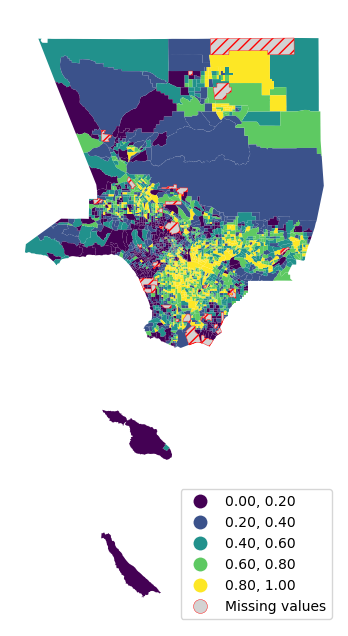

In [265]:
ax = svi.plot(
    column = 'rpl_theme_2',
    scheme = 'equal_interval',
    cmap = 'viridis',
    legend = True,
    legend_kwds = {
        'loc': 'lower right'
    },
    missing_kwds = {
        'color': 'lightgrey',
        "edgecolor": 'r',
        'linewidth': 0.3,
        "hatch": '///',
        "label": 'Missing values'
    },
)
plt.axis('off')
plt.savefig('Figures/theme2_percentile_ranking.png', bbox_inches = 'tight', dpi = 600)

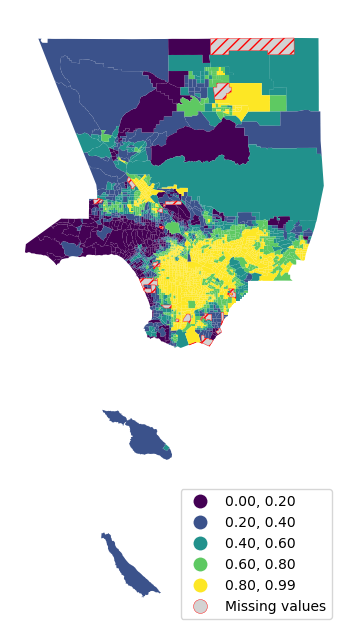

In [266]:
ax = svi.plot(
    column = 'rpl_theme_3',
    scheme = 'equal_interval',
    cmap = 'viridis',
    legend = True,
    legend_kwds = {
        'loc': 'lower right'
    },
    missing_kwds = {
        'color': 'lightgrey',
        "edgecolor": 'r',
        'linewidth': 0.3,
        "hatch": '///',
        "label": 'Missing values'
    },
)
plt.axis('off')
plt.savefig('Figures/theme3_percentile_ranking.png', bbox_inches = 'tight', dpi = 600)

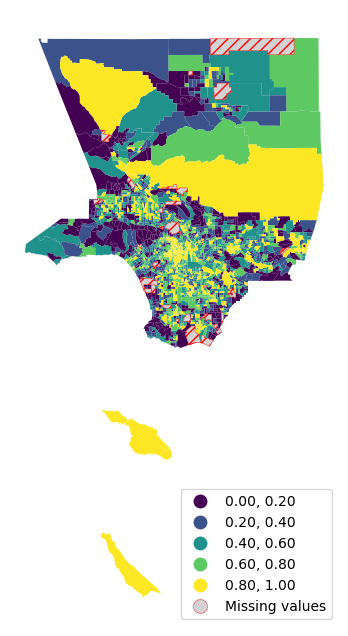

In [267]:
ax = svi.plot(
    column = 'rpl_theme_4',
    scheme = 'equal_interval',
    cmap = 'viridis',
    legend = True,
    legend_kwds = {
        'loc': 'lower right'
    },
    missing_kwds = {
        'color': 'lightgrey',
        "edgecolor": 'r',
        'linewidth': 0.3,
        "hatch": '///',
        "label": 'Missing values'
    },
)
plt.axis('off')
plt.savefig('Figures/theme4_percentile_ranking.png', bbox_inches = 'tight', dpi = 600)

In [308]:
svi['tract_area'] = svi['geometry'].area / 43560

In [305]:
lacofd_station_bounds['area'] = (lacofd_station_bounds.geometry.area) / 43560

In [307]:
lacofd_station_bounds['area'].describe()

count      174.0000
mean     11971.6202
std      26629.7300
min        325.0523
25%       2012.0352
50%       3083.6996
75%       7358.2434
max     180588.2355
Name: area, dtype: float64

In [311]:
lacofd_station_bounds['area'].sum()

np.float64(2083061.9070007885)

In [309]:
lafd_station_bounds['area'] = (lafd_station_bounds.geometry.area) / 43560

In [310]:
lafd_station_bounds['area'].describe()

count    106.0000
mean    2902.0250
std     1846.2141
min      372.1204
25%     1667.7567
50%     2486.5994
75%     3304.2780
max     9596.2625
Name: area, dtype: float64

In [312]:
lafd_station_bounds['area'].sum()

np.float64(307614.65398443106)

In [342]:
X = all_stations.geometry.get_coordinates().values.tolist()

In [356]:
skeleton = gd.RipsComplex(points = X, max_edge_length = 26400)

In [357]:
Rips_simplex_tree = skeleton.create_simplex_tree(max_dimension = 2) 

In [358]:
Rips_simplex_tree.dimension()

2

In [359]:
Rips_simplex_tree.num_vertices()

415

In [360]:
Rips_simplex_tree.num_simplices()

21058

In [361]:
BarCodes_Rips0 = Rips_simplex_tree.persistence()

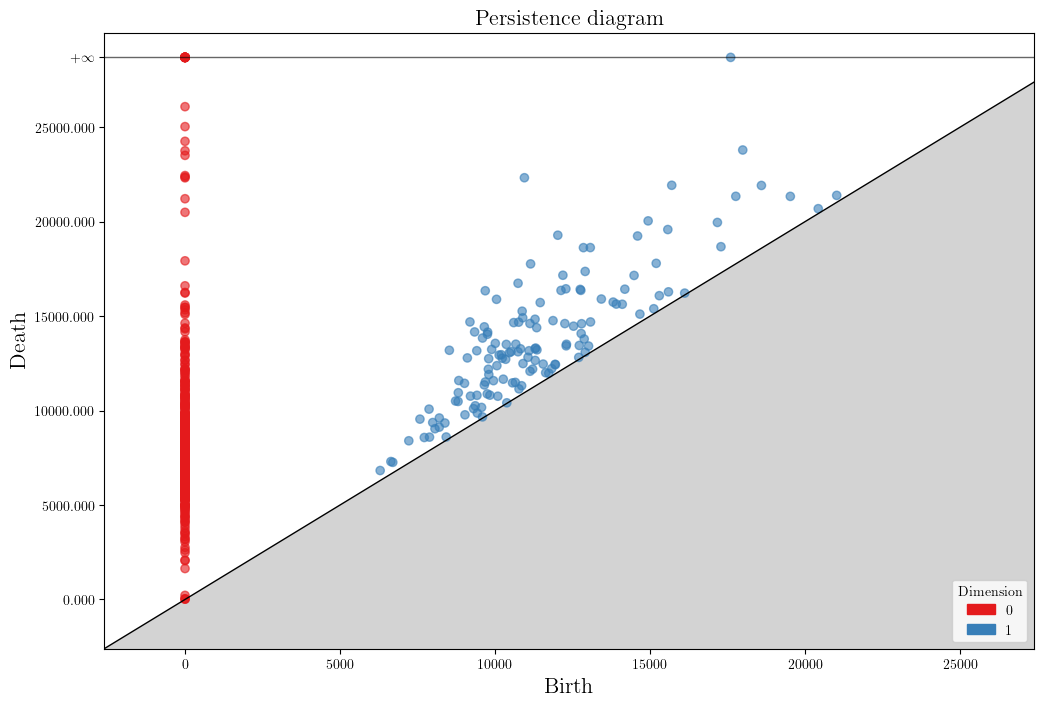

In [362]:
gd.plot_persistence_diagram(BarCodes_Rips0);

In [366]:
skeleton = gd.RipsComplex(points = X, max_edge_length = 52800)

In [367]:
Rips_simplex_tree2 = skeleton.create_simplex_tree(max_dimension = 2) 

In [369]:
Rips_simplex_tree2.dimension()

2

In [370]:
BarCodes_Rips1 = Rips_simplex_tree2.persistence()

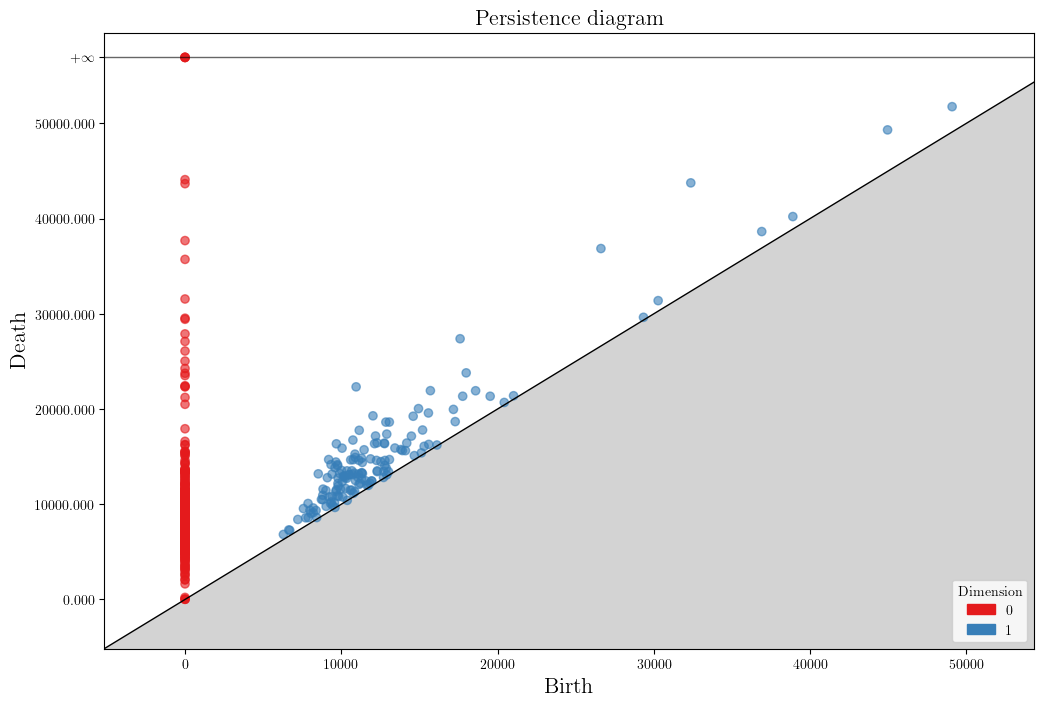

In [371]:
gd.plot_persistence_diagram(BarCodes_Rips1);

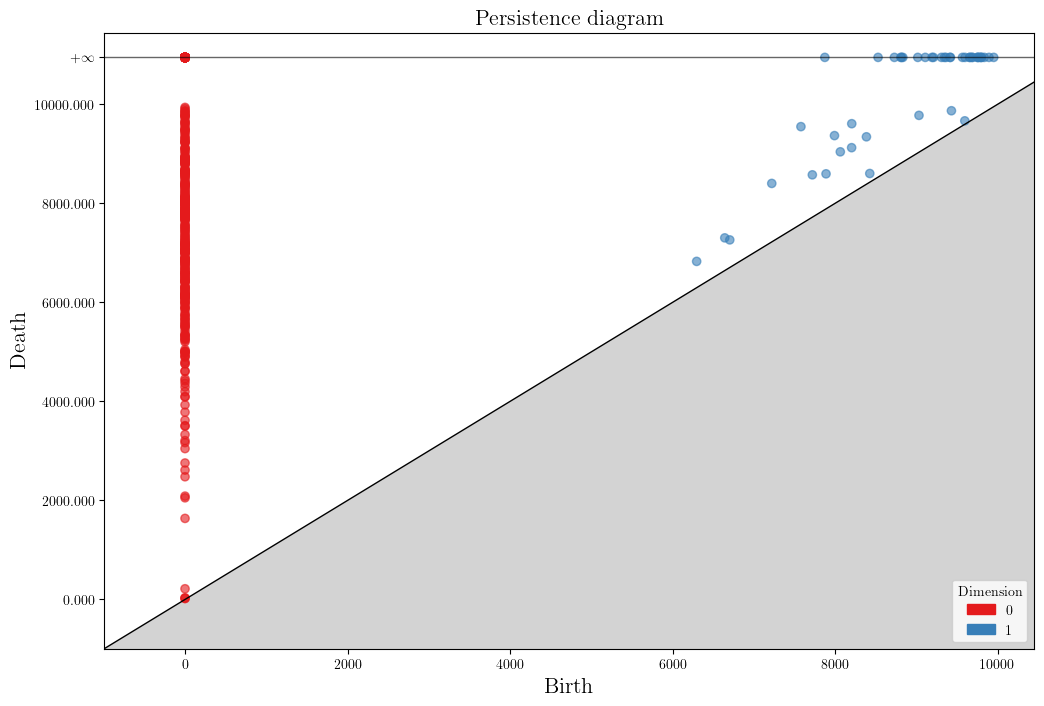

In [ ]:
rips = RipsComplex(points=X, max_edge_length=10_000)  # in feet
simplex_tree = rips.create_simplex_tree(max_dimension=2)

diag = simplex_tree.persistence()
gudhi.plot_persistence_diagram(diag)
plt.show()